# Geant4 Optical Simulation Analsys

An analysis of the geant4 data generated by shooting particles through the stack at various detector configurations

In [1]:
# Import linraries
import os
import numpy as np
import matplotlib
import pandas as pd
import scipy.constants as c
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.stats as st
from scipy.stats import kde
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
matplotlib.rcParams['figure.dpi']=100

In [4]:
# Analysis Parameters
focal = 100               # Focal Length mm
N_sent = 31361              # Number of photons sent
Area = 0.2 #mm^2              # Area of detector
L =  2*np.sqrt(Area/np.pi)    # Sensor Diameter
QE = 1                      # Quantum efficiency
n = np.array([0,0,1])       # Normal vector
nhat = n/(n.dot(n))**0.5    # Normal unit vector

# LOAD THE DATA ##########################################################
file = open("results.csv","r")
lines = [l.split(" ") for l in file.readlines()]
lines = [[L.split(",") for L in l] for l in lines]
N_hit = len(lines)
lines = [[[float(l) for l in element] for element in line] for line in lines][0:N_hit]

# SOME HELPING FUNCTIONS ##################################################

# For all the elments get the positions of hits on the plane in a new array
def getHits(lines,D):
    hits = []
    for line in (lines):
        p1 = np.array(line[0]) #Starting point 
        p2 = np.array(line[1]) #Ending point
        phat = (p2-p1)/((p2-p1).dot(p2-p1))**0.5


        l = (D-p1.dot(nhat))/phat.dot(nhat)
        hits.append((p1+phat*l).tolist())

    return np.array(hits)

# Return the number of hits that fell on the detector
def getDetectedNum(hits,R):
    detected = 0
    for hit in hits:
        if hit[0]**2+hit[1]**2<=R**2: detected+=1
    return detected

# Returns only the hits inside said diameter
def inside(hits,R):
    INSIDE = []
    for hit in hits:
        if hit[0]**2+hit[1]**2<=R**2:
            INSIDE.append(hit)
    return np.array(INSIDE)

In [3]:
# Print Hits VS Position Curve #########################################
# Part #1 Get the data

# Plot parameters
zmin = -50          # Minimum Distance behind the focal point
zmax =  50          # Maximum distance in from of the focal point
resolution = 1000   # Number of points

# Obtain the rate at certain distances
dist = np.linspace(zmin+focal,zmax+focal,resolution)
hits = np.array([getDetectedNum(getHits(lines,z),L/2) for z in tqdm(dist)])


100%|██████████| 1000/1000 [09:43<00:00,  1.71it/s]


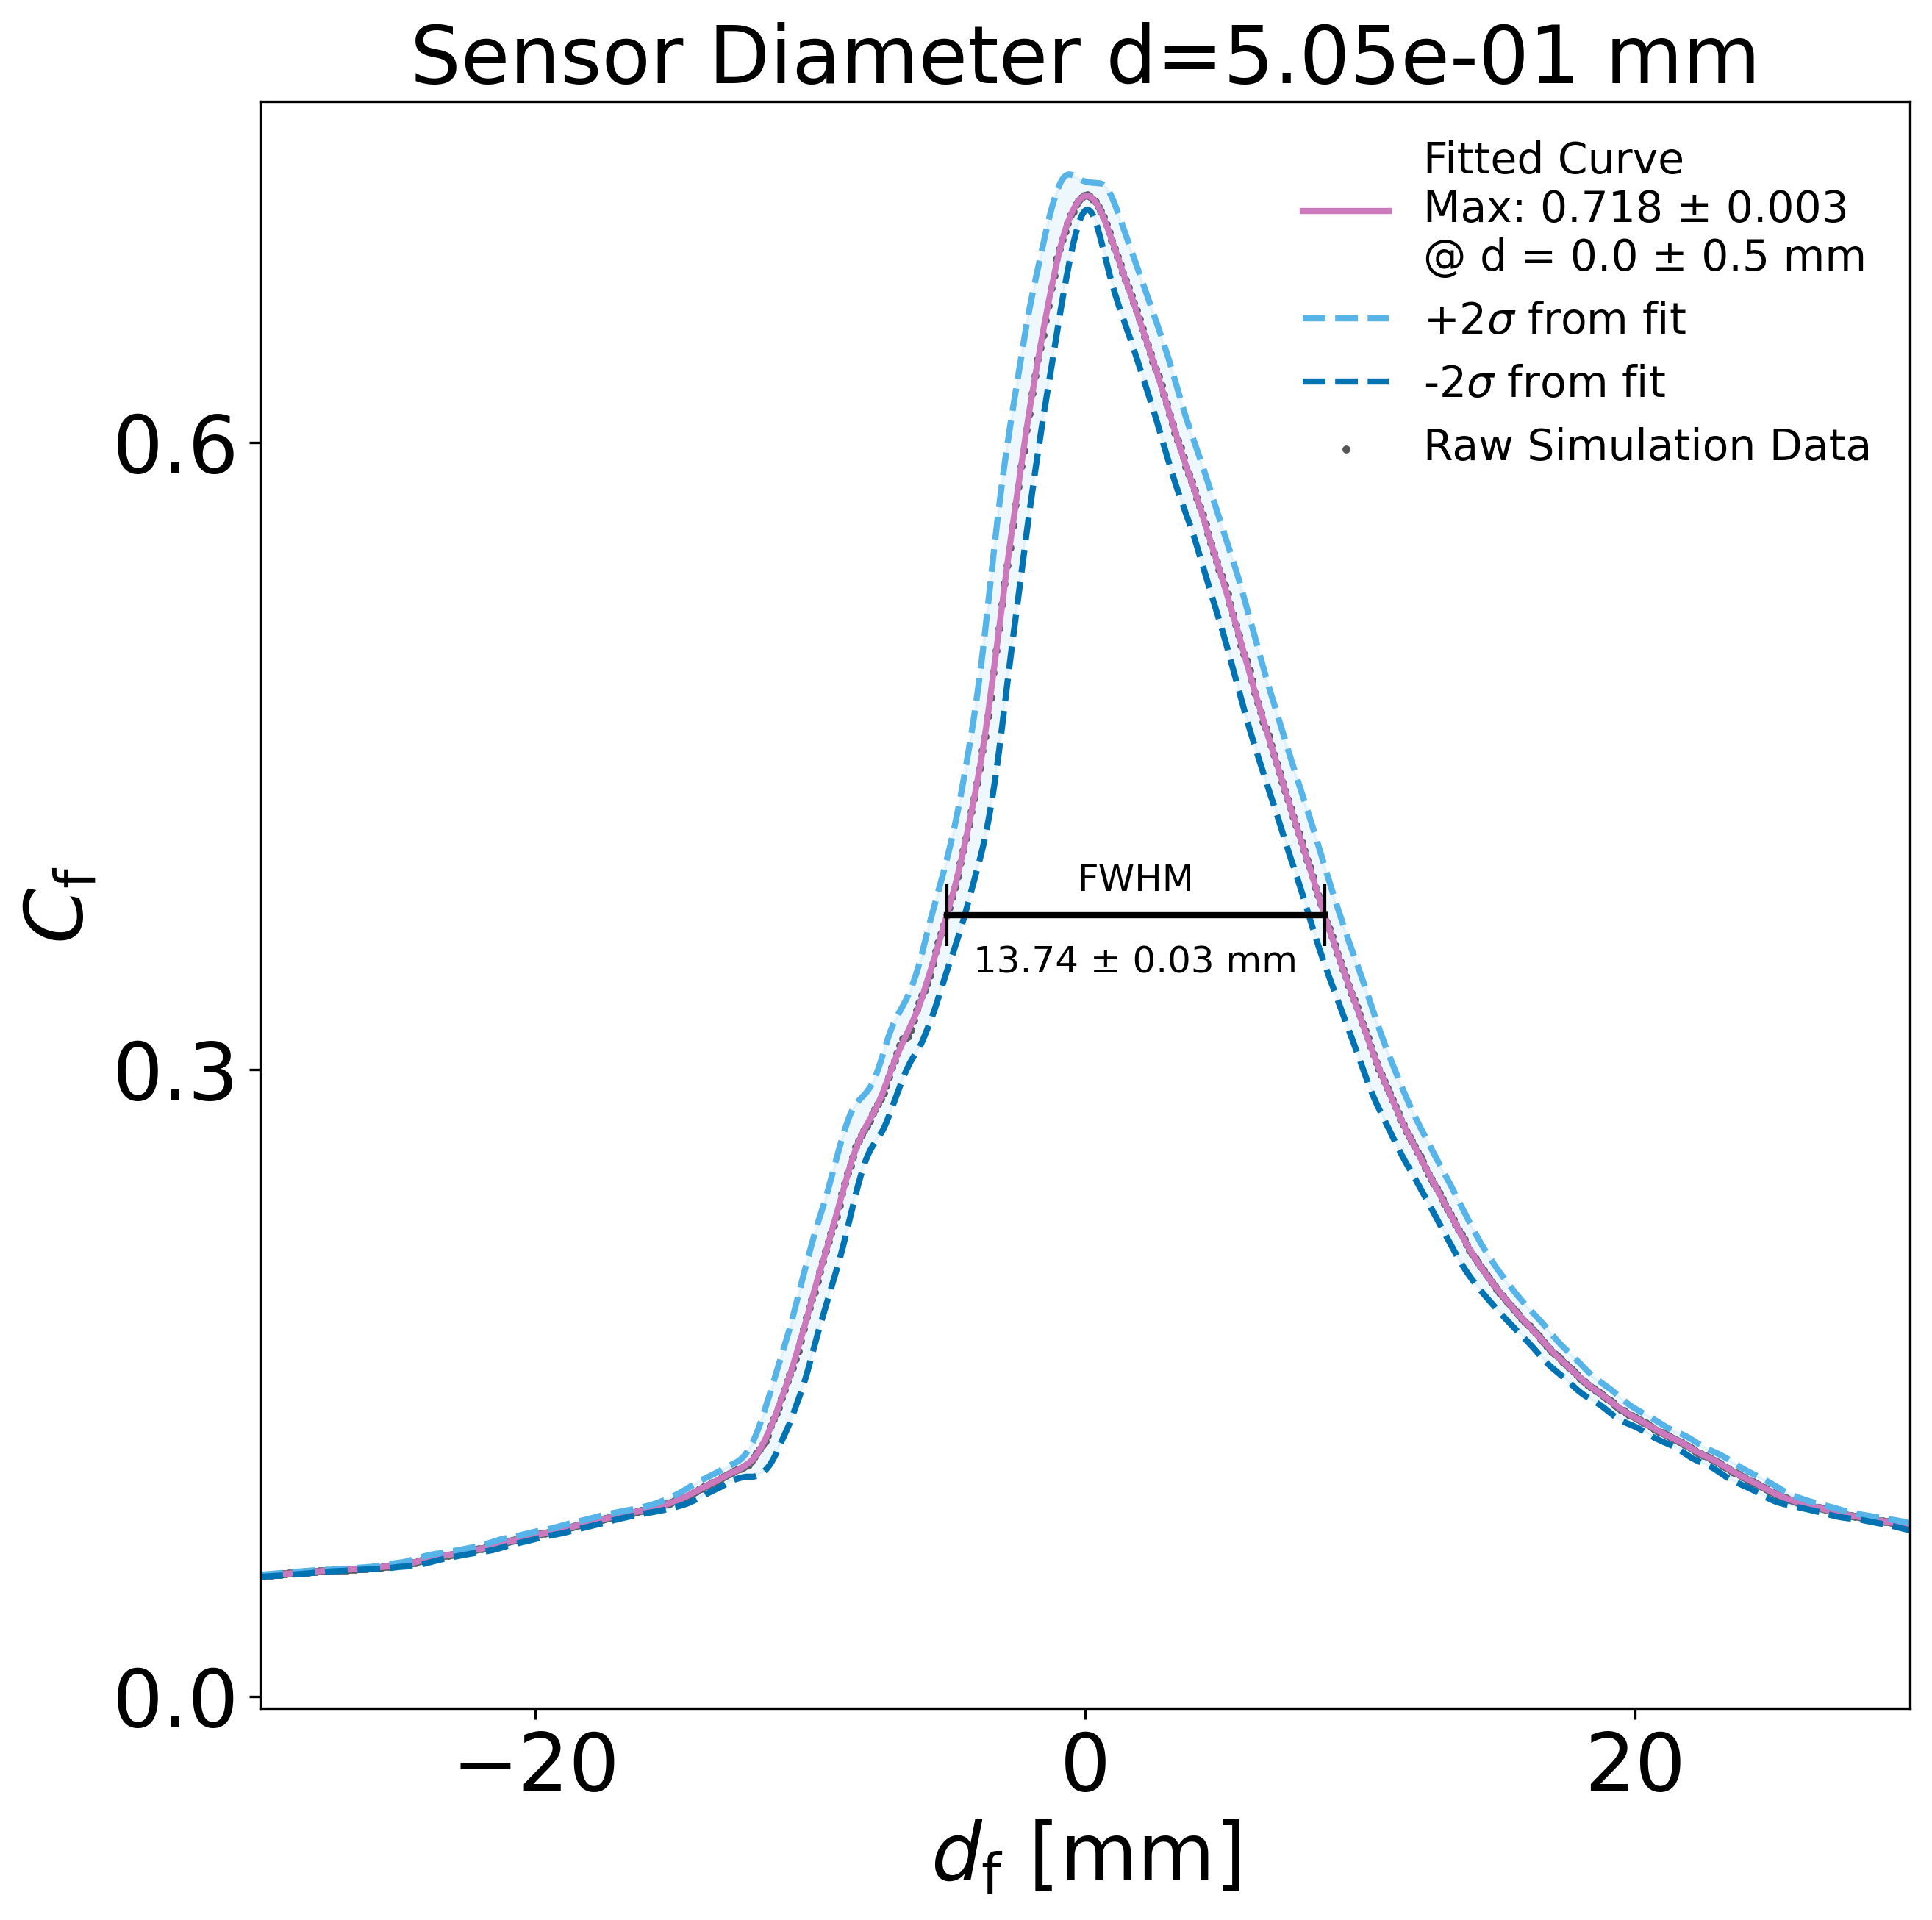

In [15]:
# Print Hits VS Position Curve #########################################
# Part #2 Analyse and plot

dist = np.linspace(zmin+focal-10.3,zmax+focal-10.3,resolution)

#Calculate the standard deviation for a moving window.
WinL = int(resolution/100)
std = []
for i in range(len(hits)):
    if i <= int(WinL/2):
        std.append(np.std(hits[0:WinL]))
    elif i+int(WinL/2) >= len(hits):
        std.append(np.std(hits[len(hits)-1-WinL:len(hits)-1]))
    else:
        std.append(np.std(hits[i-int(WinL/2):i+int(WinL/2)]))
std = np.array(std)

#Get the best fit
Npts = 10000
d = np.linspace(min(dist),max(dist),Npts)
f = savgol_filter(hits, int(resolution/100)+5,2)
S = savgol_filter(std,  int(resolution/100)+5,2)
i = interp1d(dist,f,kind='cubic')
s = interp1d(dist,S,kind='cubic')
fit = i(d)
STD = s(d)

#Calculate FWHM
m = min(fit)
M = max(fit)
HM = m + (M-m)/2
HM = np.array([HM]*len(fit))
diffs = np.argwhere(np.diff(np.sign(fit - HM))).flatten()
diffsSTDH = np.argwhere(np.diff(np.sign(fit + STD - HM))).flatten()
diffsSTDL = np.argwhere(np.diff(np.sign(fit - STD - HM))).flatten()
FWHM = abs(d[diffs[0]]-d[diffs[1]])
sigmaFWHM = abs(d[diffsSTDH[0]]-d[diffsSTDL[0]]+d[diffsSTDH[1]]-d[diffsSTDL[1]])/4

diffsSTDH = np.argwhere(np.diff(np.sign(fit + STD - max(fit)))).flatten()
diffsSTDL = np.argwhere(np.diff(np.sign(fit - STD - max(fit)))).flatten()
sigmaDmax = abs(d[diffsSTDH[0]]-d[diffsSTDH[1]])/2



# PLOTTING CONFIG ################################################################################
import seaborn as sns
SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26
LINEWIDTH = 4
MARKERSIZE = 5
FIGSIZE = (9.652,9.652)
palette = sns.color_palette("colorblind")
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=LINEWIDTH)  # thickness of lines
plt.rc('lines', markersize=MARKERSIZE)  # size of the marker


#Plotting
fig = plt.figure(figsize = FIGSIZE,dpi=300)
ax1 = fig.add_subplot(111)
ax1.set_title("Sensor Diameter d=%.2e mm"%L)

#plot data points
ax1.scatter(dist-focal,hits/N_sent*QE,s=10,marker=".",c="#555555",label="Raw Simulation Data")

#plot best fit
ax1.plot(d-focal,fit/N_sent*QE,c=palette[4],ls='-',lw=2,
         label="Fitted Curve\nMax: %.3f ± %.3f\n@ d = %.1f ± %.1f mm"
         %(max(fit/N_sent*QE),STD[fit.tolist().index(max(fit))]/N_sent*QE,
           d[fit.tolist().index(max(fit))]-focal,sigmaDmax))

#Plot Std Curves
Nstd = 2
ax1.plot(d-focal,(fit+STD*Nstd)/N_sent*QE,c=palette[9],ls='--',lw=2,
         label=r"+%d$\sigma$ from fit"%Nstd)
ax1.plot(d-focal,(fit-STD*Nstd)/N_sent*QE,c=palette[0],ls='--',lw=2,
         label=r"-%d$\sigma$ from fit"%Nstd)
ax1.fill_between(d-focal,(fit+STD*Nstd)/N_sent*QE,(fit-STD*Nstd)/N_sent*QE,alpha=0.1,color=palette[9])

#plot FWHM
ax1.plot([d[diffs[0]]-focal,d[diffs[1]]-focal],[HM[0]/N_sent*QE]*2,c='black',marker='|',ms = 20,lw=2)
ax1.text((d[diffs[0]]+d[diffs[1]])/2-focal,HM[0]/N_sent*QE+0.025,
         "FWHM\n\n%.2f ± %.2f mm"%(FWHM,10*sigmaFWHM),
         horizontalalignment='center',verticalalignment='top',fontsize=12)


#Plot adjustment
ax1.set_xlabel(r"$d_{\rm f}$ [mm]")
ax1.set_ylabel(r"$C_{\rm f}$")
# ax1.grid(which='minor', linestyle='--', linewidth='0.05', color='black',alpha=0.5)
# ax1.grid(which='major', linestyle='-', linewidth='0.08', color='black',alpha=1)
# ax1.minorticks_on()
# ax1.grid(True)
ax1.legend(frameon=False,loc='upper right',fontsize=14)
# ax1.tick_params(axis='both',which='both',direction='in')
ax1.set_xlim(-30,30)
ax1.set_yticks([0,0.3, 0.6]);
ax1.set_xticks([-20,0,20]);

Photons sent: 31361
Photons Incident: 31361
Rate: 1.000
Position: 110.10 mm


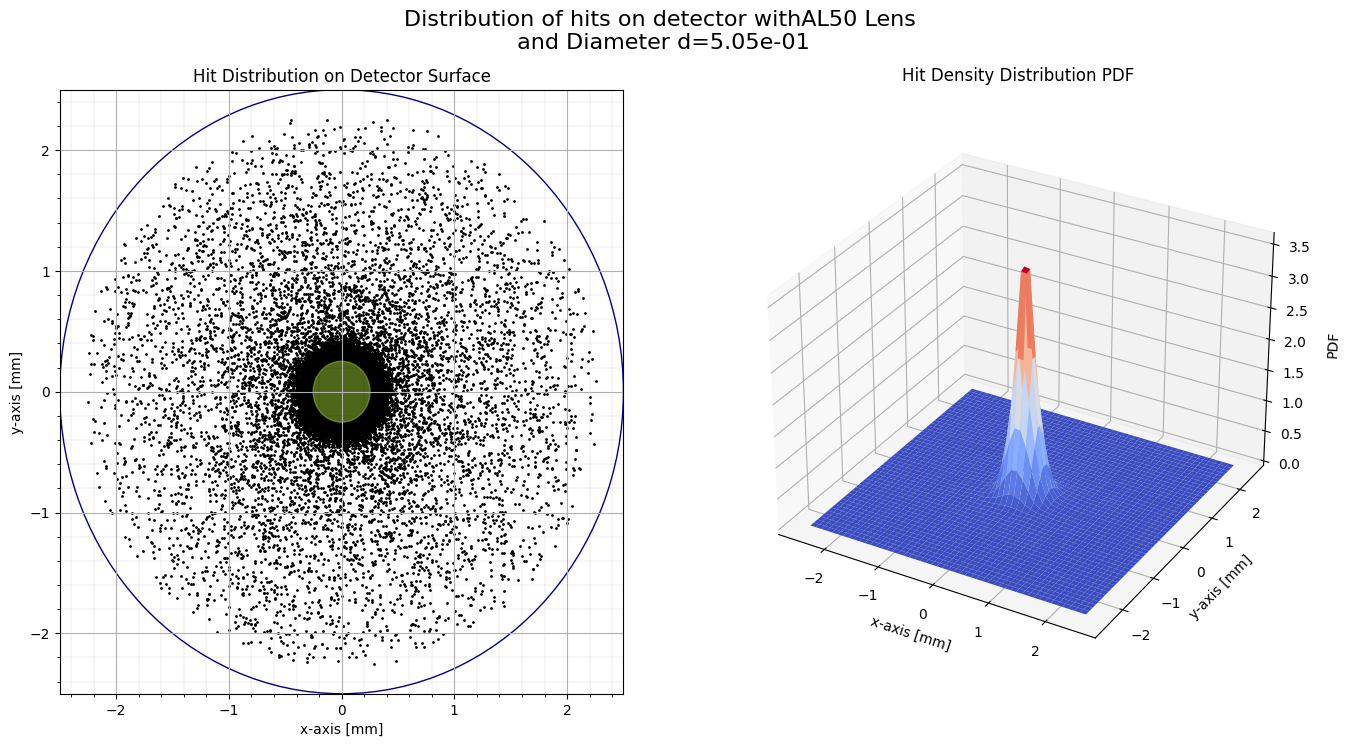

In [7]:
# Get photons incident on a plane ###################################################################################
LL = 5   #mm
z = focal + 10.1 #mm 15514
Name = "AL50 Lens"

#Get the data for the point
simdata = inside(getHits(lines,z),LL/2).T

#Print relevant info
print("Photons sent: %d\nPhotons Incident: %d\nRate: %.3f"%(N_sent,len(simdata[0]),len(simdata[0])/N_sent))
print("Position: %.2f mm"%z)

#Create the figure
fig = plt.figure(figsize=(16,8))
fig.suptitle("Distribution of hits on detector with" + Name + "\n and Diameter d=%.2e"%(L),fontsize=16)

#Figure has two plots: Detector Surface (Left) and Detector Hits Density plot (Rigt)
#Detector Surface
ax1 = fig.add_subplot(121)
ax1.scatter(simdata[0],simdata[1],c='k',s=1)
ax1.add_artist(plt.Circle((0, 0), LL/2, color='darkblue',fill=False)) #Circle to denote the boundary of the detector
ax1.add_artist(plt.Circle((0, 0), L/2, color='yellowgreen',fill=True,alpha=0.5)) #Circle to denote the boundary of the detector
ax1.set_xlim(-LL/2,LL/2)
ax1.set_ylim(-LL/2,LL/2)
ax1.grid(True)
ax1.grid(which='minor', linestyle='-', linewidth='0.05', color='black')
ax1.minorticks_on()
ax1.set_xlabel("x-axis [mm]")
ax1.set_ylabel("y-axis [mm]")
ax1.set_title("Hit Distribution on Detector Surface")

#Detector Hits Density plot
Npts = 50
X,Y = np.meshgrid(np.linspace(-LL/2,LL/2,Npts),np.linspace(-LL/2,LL/2,Npts))
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([simdata[0],simdata[1]])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, X.shape)*len(simdata[0])/N_sent

ax2 = fig.add_subplot(122,projection='3d')
ax2.set_xlabel("x-axis [mm]")
ax2.set_ylabel("y-axis [mm]")
ax2.set_zlabel("  \nPDF")
# ax2.set_zlim(0,3.5)
surf = ax2.plot_surface(X, Y, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
x = ax2.set_title("Hit Density Distribution PDF\n")

MovieWriter imagemagick unavailable; using Pillow instead.


Photons sent: 31361
Photons Incident: 31997
Rate: 1.020
Position: 110.10 mm
(31997, 2)
(31997, 2)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252


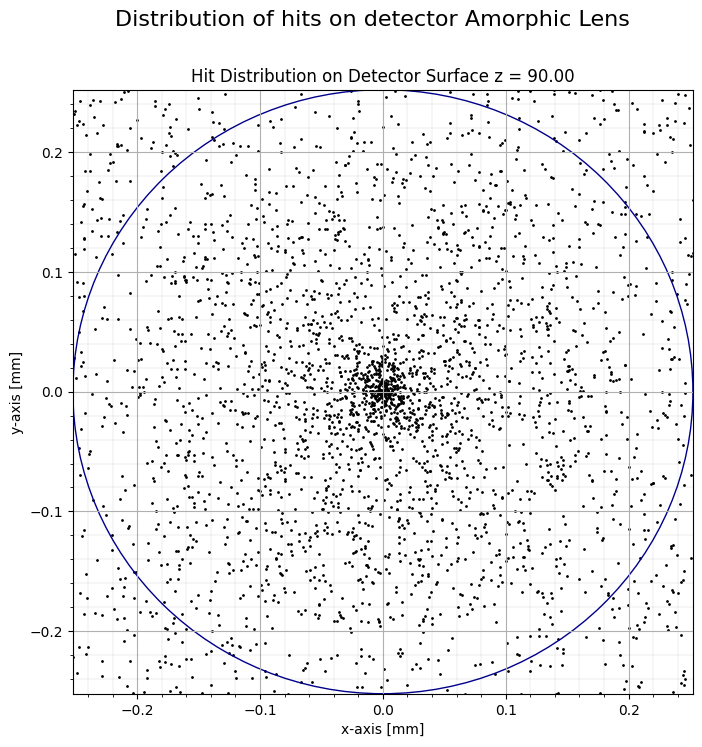

In [123]:
#Generate the animation##############################################################################################
N_sent = 31361              # Number of photons sent
Area = 0.2 #mm^2              # Area of detector
L =  2*np.sqrt(Area/np.pi)    # Sensor Diameter
n = np.array([0,0,1])
nhat = n/(n.dot(n))**0.5
Name = "Amorphic Lens"


#Get a list of filenames in the directory
file = open("results.csv","r")
lines = [l.split(" ") for l in file.readlines()]
lines = [[L.split(",") for L in l] for l in lines]
lines = [[[float(l) for l in element] for element in line] for line in lines]#[0:1000]

#For all the elments get the positions of hits on the plane in a new array
def getHits(lines,D):
    hits = []
    for line in (lines):
        p1 = np.array(line[0]) #Starting point
        p2 = np.array(line[1]) #Ending point
        phat = (p2-p1)/((p2-p1).dot(p2-p1))**0.5


        l = (D-p1.dot(nhat))/phat.dot(nhat)
        hits.append((p1+phat*l).tolist())

    return np.array(hits)

#Return the number of hits that fell on the detector
def getDetectedNum(hits,R):
    detected = 0 
    for hit in hits: 
        if hit[0]**2+hit[1]**2<=R**2: detected+=1
    return detected

#Get the data for the point
Z = np.linspace(90,130,500)
simdata = getHits(lines,Z[0]).T

#Print relevant info
print("Photons sent: %d\nPhotons Incident: %d\nRate: %.3f"%(N_sent,len(simdata[0]),len(simdata[0])/N_sent))
print("Position: %.2f mm"%z)

#Create the figure
fig = plt.figure(figsize=(8,8))
fig.suptitle("Distribution of hits on detector " + Name,fontsize=16)

#Figure has two plots: Detector Surface (Left) and Detector Hits Density plot (Rigt)
#Detector Surface
ax1 = fig.add_subplot(111)
hits = ax1.scatter(simdata[0],simdata[1],c='k',s=1)
ax1.add_artist(plt.Circle((0, 0), L/2, color='darkblue',fill=False)) #Circle to denote the boundary of the detector
ax1.set_xlim(-L/2,L/2)
ax1.set_ylim(-L/2,L/2)
ax1.grid(True)
ax1.grid(which='minor', linestyle='-', linewidth='0.05', color='black')
ax1.minorticks_on()
ax1.set_xlabel("x-axis [mm]")
ax1.set_ylabel("y-axis [mm]")
ax1.set_title("Hit Distribution on Detector Surface")

def initAnim():
    print(np.shape(simdata[0:2].T))
    hits.set_offsets(simdata[0:2].T)
    ax1.set_title("Hit Distribution on Detector Surface z = %.2f"%Z[0])
    
    return hits,
    
def update(i):
    print(i)
    simdata = getHits(lines,Z[i]).T
    # print(np.shape(simdata).T)
    hits.set_offsets(simdata[0:2].T)
    ax1.set_title("Hit Distribution on Detector Surface z = %.2f"%Z[0])
    
    return hits,
    
anim = animation.FuncAnimation(fig, update, init_func=initAnim, frames=len(Z), interval=20, blit=True)
anim.save('hits.gif',writer='imagemagick') 